In [ ]:
!pip3 install darts plotly

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

from darts import TimeSeries

from darts.datasets import EnergyDataset

import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Read a pandas DataFrame
df = pd.read_parquet('../../Data/ldn_df2.parquet')
df

,Index,LCLid,DateTime,KWHhh
0,0,MAC000002,2012-10-13T00:00:00,0.263
1,1,MAC000002,2012-10-13T00:30:00,0.269
2,2,MAC000002,2012-10-13T01:00:00,0.275
3,3,MAC000002,2012-10-13T01:30:00,0.256
4,4,MAC000002,2012-10-13T02:00:00,0.211
...,...,...,...,...
20875,20875,MAC005567,2014-02-27T21:30:00,0.076
20876,20876,MAC005567,2014-02-27T22:00:00,0.173
20877,20877,MAC005567,2014-02-27T22:30:00,0.205
20878,20878,MAC005567,2014-02-27T23:00:00,0.221


In [21]:
df = pd.read_csv('../../Data/london_clean/cleaned_household_MAC000002.csv')
df

,Index,LCLid,StdorToU,DateTime,KWHhh,TimeOfDay
0,0,MAC000002,Std,2012-10-13T00:00:00,0.263,00:00:00
1,1,MAC000002,Std,2012-10-13T00:30:00,0.269,00:30:00
2,2,MAC000002,Std,2012-10-13T01:00:00,0.275,01:00:00
3,3,MAC000002,Std,2012-10-13T01:30:00,0.256,01:30:00
4,4,MAC000002,Std,2012-10-13T02:00:00,0.211,02:00:00
...,...,...,...,...,...,...
24139,24139,MAC000002,Std,2014-02-27T21:30:00,0.483,21:30:00
24140,24140,MAC000002,Std,2014-02-27T22:00:00,0.416,22:00:00
24141,24141,MAC000002,Std,2014-02-27T22:30:00,1.350,22:30:00
24142,24142,MAC000002,Std,2014-02-27T23:00:00,1.247,23:00:00


In [22]:
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['StdorToU'], axis=1 , inplace=True)
df.drop(['TimeOfDay'], axis=1 , inplace=True)
df.drop(["LCLid"], axis=1, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.loc[~df["DateTime"].duplicated(), :]
df.rename(columns={'KWH/hh (per half hour) ': 'KWH'} , inplace=True)
df

,Index,DateTime,KWHhh
0,0,2012-10-13 00:00:00,0.263
1,1,2012-10-13 00:30:00,0.269
2,2,2012-10-13 01:00:00,0.275
3,3,2012-10-13 01:30:00,0.256
4,4,2012-10-13 02:00:00,0.211
...,...,...,...
24139,24139,2014-02-27 21:30:00,0.483
24140,24140,2014-02-27 22:00:00,0.416
24141,24141,2014-02-27 22:30:00,1.350
24142,24142,2014-02-27 23:00:00,1.247


In [73]:
import glob
df = pd.concat([pd.read_csv(x) for x in sorted(glob.glob("../../Data/london_clean/*.csv"))[:20]])

In [81]:

df['LCLid'] = df['LCLid'].apply(lambda x: x[3:])


In [83]:
df

,Index,LCLid,StdorToU,DateTime,KWHhh,TimeOfDay
0,0,000002,Std,2012-10-13T00:00:00,0.263,00:00:00
1,1,000002,Std,2012-10-13T00:30:00,0.269,00:30:00
2,2,000002,Std,2012-10-13T01:00:00,0.275,01:00:00
3,3,000002,Std,2012-10-13T01:30:00,0.256,01:30:00
4,4,000002,Std,2012-10-13T02:00:00,0.211,02:00:00
...,...,...,...,...,...,...
39019,39019,000021,Std,2014-02-27T21:30:00,0.404,21:30:00
39020,39020,000021,Std,2014-02-27T22:00:00,0.500,22:00:00
39021,39021,000021,Std,2014-02-27T22:30:00,0.475,22:30:00
39022,39022,000021,Std,2014-02-27T23:00:00,0.414,23:00:00


In [28]:
helper.find_gaps(df)

107 gaps with median gap duration: 0 days 15:30:00
289     4 days 01:00:00
311     0 days 01:00:00
305     0 days 17:00:00
305     0 days 17:00:00
306     0 days 16:30:00
             ...       
1       0 days 00:39:28
1       0 days 00:35:51
309   203 days 15:00:00
312    93 days 13:30:00
308     9 days 15:30:00
Name: DateTime, Length: 107, dtype: timedelta64[ns]


In [24]:
df["DateTime"] = df["index"].apply(lambda x: df["DateTime"][0] + (x * pd.Timedelta(minutes=30)))
df["DateTime"] = df["DateTime"].apply(lambda x: x.strftime("%Y-%m-%d"))

Text(0.5, 1.0, 'Daily peak usage in household')

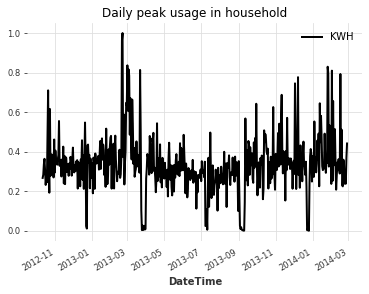

In [25]:
df_max = df.groupby(df["DateTime"].astype(str).str.split(" ").str[0]).max()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(df_max, "DateTime", ["KWH"])
    )
).astype(np.float32)
series.plot()
plt.title("Daily peak usage in household")

In [87]:
## Create data from 

my_time_series_dataset = []
for x in sorted(glob.glob("../../Data/london_clean/*.csv"))[:20]:
    series = TimeSeries.from_csv(x, time_col='DateTime', value_cols='KWHhh')
    my_time_series_dataset.append(series)

In [ ]:
series = TimeSeries.from_dataframe(df_max, value_cols=['KWH'], time_col="index", fill_missing_dates=True)

In [15]:
train, val = series.split_after(0.85)
#train, val = series[:-48], series[-48:]


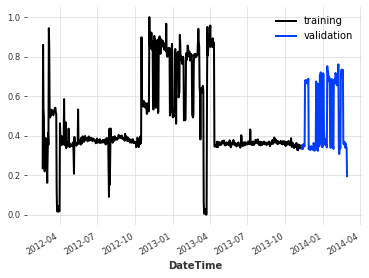

In [16]:
train.plot(label="training")
val.plot(label="validation")

In [96]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=3,
    layer_widths=512,
    n_epochs=200,
    nr_epochs_val_period=1,
    batch_size=200,
    model_name="nbeats_run",
    # pl_trainer_kwargs={
    #   "accelerator": "gpu",
    #   "devices": 2,
    #   "strategy": "dp"
    # },
)

In [97]:
model_nbeats.fit(my_time_series_dataset, verbose=True)

[2022-04-26 12:40:02,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 780720 samples.
[2022-04-26 12:40:02,413] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 780720 samples.
[2022-04-26 12:40:02,470] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-26 12:40:02,470] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-26 12:40:02,472] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-26 12:40:02,472] WARNING | darts.models.forecasting.torch_forecasting_model | D

Epoch 0:  10%|█         | 394/3904 [01:48<16:06,  3.63it/s, loss=0.0417]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [19]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        f"MSE: {r2_score(ts_transformed.univariate_component(0), pred_series)}"
    )
    plt.legend()

In [26]:
pred_series = model_nbeats.historical_forecasts(
    series,
    forecast_horizon=1,
    stride=2,
    retrain=False,
    verbose=True,
)

  0%|          | 0/127 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

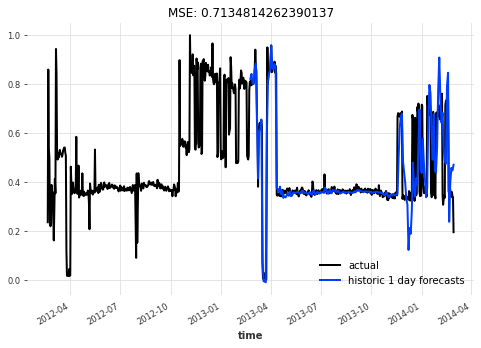

In [21]:
display_forecast(pred_series, series, "1 day")

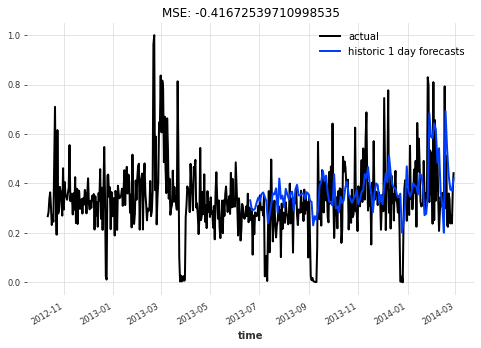

In [27]:
display_forecast(pred_series, series, "1 day")

In [55]:
from darts.models import TCNModel

model_en = TCNModel(
    input_chunk_length=30,
    output_chunk_length=7,
    n_epochs=200,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": 1,
    },    
)

In [56]:
model_en.fit(series, verbose=True)

[2022-04-02 14:41:47,717] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 468 samples.
[2022-04-02 14:41:47,717] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 468 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 468 samples.
[2022-04-02 14:41:47,719] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2022-04-02 14:41:47,719] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
INFO:darts.models.forecasting.tcn_model:Number of layers chosen: 3
[2022-04-02 14:41:47,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-04-02 14:41:47,722] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 32-bits; casting model to float32.
[2022-04-02 1

Training: 0it [00:00, ?it/s]

In [57]:
pred_series = model_en.historical_forecasts(
    series,
    start=0.264,
    forecast_horizon=7,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/366 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 15it [00:00, ?it/s]

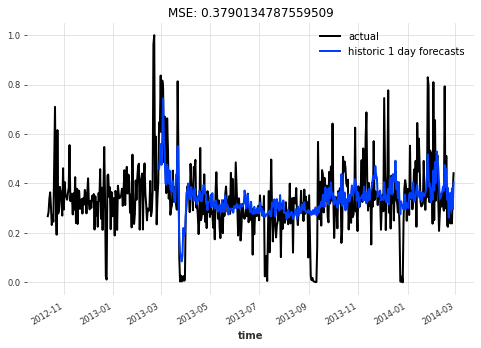

In [58]:
display_forecast(pred_series, series, "1 day")